In [5]:
import matplotlib
import numpy
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn, optim

M = 4
d = 2048
n = 10
n_ = 10
dh = 1024
dv = 256
cp = 1


class TF(nn.Module):
    def __init__(self):
        super().__init__()
        self.q = nn.Linear(d, dh, bias=False)
        self.k = nn.Linear(d, dh, bias=False)
        self.v = nn.Linear(d, dv, bias=False)
        self.fc = nn.Linear(dv, 1, bias=False)
        self.fc.requires_grad_(False)
        self.q.weight.data /= 64
        self.k.weight.data /= 64
        self.v.weight.data /= 64

    def compute_V(self, x):
        v = self.v(x)
        z = self.fc(v)
        return z[0, 0, 0], z[0, 1, 0]

    def attn_token(self, x):
        q = self.q(x)
        k = self.k(x)
        qk = torch.matmul(q, k.transpose(1, 2))
        inner_product1, innerproduct2, inner_product3, innerproduct4 = qk[0, 0, 0], qk[0, 0, 1], qk[0, 2, 0], qk[
            0, 2, 1]
        attn = qk.softmax(dim=2)
        attn = torch.sum(attn, dim=1).unsqueeze(1)
        attn /= M
        return attn[0, 0, 0], attn[0, 0, 1], inner_product1, innerproduct2, inner_product3, innerproduct4

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        qk = torch.matmul(q, k.transpose(1, 2))
        attn = qk.softmax(dim=2)
        attn = torch.sum(attn, dim=1).unsqueeze(1)
        attn /= M
        z = torch.matmul(attn, v).squeeze(1)
        return self.fc(z)


def make_mu1(mu):
    mu1 = numpy.zeros(d)
    mu1[0] = mu
    return mu1


def make_mu2(mu):
    mu2 = numpy.zeros(d)
    mu2[1] = mu
    return mu2


def make_noise(strength):
    return numpy.random.normal(0, strength, size=d)


def track():
    D = []
    D_Y = []
    D_ = []
    D_Y_ = []

    mu1 = make_mu1(15)
    mu2 = make_mu2(15)

    for i in range(int(n / 2)):
        X = mu1.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.05)).reshape(1, d)), 0)
        D.append(X)
        D_Y.append([1.]) if np.random.rand() > 0.001 else D_Y.append([-1.])
        X = mu2.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.05)).reshape(1, d)), 0)
        D.append(X)
        D_Y.append([-1.]) if np.random.rand() > 0.001 else D_Y.append([1.])

    D = torch.tensor(D, dtype=torch.float32).cuda()
    D_Y = torch.tensor(D_Y).cuda()

    for i in range(int(n_ / 2)):
        X = mu1.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.05)).reshape(1, d)), 0)
        D_.append(X)
        D_Y_.append([1.])
        X = mu2.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(0.05)).reshape(1, d)), 0)
        D_.append(X)
        D_Y_.append([-1.])

    D_ = torch.tensor(D_, dtype=torch.float32).cuda()
    D_Y_ = torch.tensor(D_Y_).cuda()

    model = TF().cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0)
    loss_fn = nn.SoftMarginLoss().cuda()
    EPOCHS = 500

    training_loss = []
    test_loss = []
    attn_signals = []
    attn_noises = []
    V_signals = []
    V_noises = []
    inner_product_signals = []
    inner_product_noises = []
    inner_product_signals2 = []
    inner_product_noises2 = []

    for epoch in range(1, EPOCHS + 1):
        model.train()
        optimizer.zero_grad()
        output = model(D)

        loss = loss_fn(output, D_Y)
        loss.backward()
        optimizer.step()
        training_loss.append(loss.item())

        model.eval()
        output = model(D_)
        loss = loss_fn(output, D_Y_)
        test_loss.append(loss.item())

        attn_signal, attn_noise, inner_product_signal, inner_product_noise, inner_product_signal_, inner_product_noise_ = model.attn_token(
            D[0: 1])
        attn_signals.append(attn_signal.cpu().detach().numpy())
        attn_noises.append(attn_noise.cpu().detach().numpy())
        inner_product_signals.append(inner_product_signal.cpu().detach().numpy())
        inner_product_noises.append(inner_product_noise.cpu().detach().numpy())
        inner_product_signals2.append(inner_product_signal_.cpu().detach().numpy())
        inner_product_noises2.append(inner_product_noise_.cpu().detach().numpy())
        v_signal, v_noise = model.compute_V(D[0: 1])
        V_signals.append(v_signal.cpu().detach().numpy())
        V_noises.append(v_noise.cpu().detach().numpy())
    return training_loss, test_loss, attn_signals, attn_noises, V_signals, V_noises, inner_product_signals, inner_product_noises, inner_product_signals2, inner_product_noises2


training_loss_list = []
test_loss_list = []
attn_signals_list = []
attn_noises_list = []
V_signals_list = []
V_noises_list = []
inner_product_signals_list = []
inner_product_noises_list = []
inner_product_signals2_list = []
inner_product_noises2_list = []

for i in range(20):
    print(i)
    training_loss, test_loss, attn_signals, attn_noises, V_signals, V_noises, inner_product_signals, inner_product_noises, inner_product_signals2, inner_product_noises2 = track()
    training_loss_list.append(numpy.array(training_loss))
    test_loss_list.append(numpy.array(test_loss))
    attn_signals_list.append(numpy.array(attn_signals))
    attn_noises_list.append(numpy.array(attn_noises))
    V_signals_list.append(numpy.array(V_signals))
    V_noises_list.append(numpy.array(V_noises))
    inner_product_signals_list.append(numpy.array(inner_product_signals))
    inner_product_noises_list.append(numpy.array(inner_product_noises))
    inner_product_signals2_list.append(numpy.array(inner_product_signals2))
    inner_product_noises2_list.append(numpy.array(inner_product_noises2))

    
np.savetxt('harm_training_loss_0.001.npy', training_loss_list)   
np.savetxt('harm_test_loss_list_0.001.npy', test_loss_list)   

np.savetxt('harm_attn_signals_0.001.npy', attn_signals_list)   
np.savetxt('harm_attn_noises_list_0.001.npy', attn_noises_list)   
    
np.savetxt('harm_V_signals_0.001.npy', V_signals_list)   
np.savetxt('harm_V_noises_list_0.001', V_noises_list)   
    
    
# plt.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# matplotlib.rcParams['xtick.labelsize'] = 13
# matplotlib.rcParams['ytick.labelsize'] = 13
# matplotlib.rcParams['figure.figsize'] = [8, 6]

# plt.figure(0)
# plt.errorbar(np.array(range(500)), np.mean(np.array(training_loss_list), axis=0),
#              yerr=2 * np.std(np.array(training_loss_list), axis=0), errorevery=50, label="Training Loss", linewidth=3)
# plt.errorbar(np.array(range(500)), np.mean(np.array(test_loss_list), axis=0),
#              yerr=2 * np.std(np.array(test_loss_list), axis=0), errorevery=50, label="Test Loss", linewidth=3)
# plt.xlabel('Training Iterations t', size=20)
# plt.legend()
# plt.savefig('loss_harmful.pdf', dpi=600, bbox_inches='tight')

# plt.figure(1)
# plt.errorbar(np.array(range(500)), np.mean(np.array(attn_signals_list), axis=0),
#              yerr=2 * np.std(np.array(attn_signals_list), axis=0), errorevery=50,
#              label=r"attention on signal $\mathbf{\mu}_+$", linewidth=3)
# plt.errorbar(np.array(range(500)), np.mean(np.array(attn_noises_list), axis=0),
#              yerr=2 * np.std(np.array(attn_noises_list), axis=0), errorevery=50,
#              label=r"attention on noise $\mathbf{\xi}_2$", linewidth=3)
# plt.xlabel('Training Iterations t', size=20)
# plt.legend()
# plt.savefig('attention_harmful.pdf', dpi=600, bbox_inches='tight')

# plt.figure(2)
# plt.errorbar(np.array(range(500)), np.mean(np.array(V_signals_list), axis=0),
#              yerr=2 * np.std(np.array(V_signals_list), axis=0), errorevery=50,
#              label=r"$\mathbf{\mu}_+^\top \mathbf{W}_V^{(t)} \mathbf{w}_O$", linewidth=3)
# plt.errorbar(np.array(range(500)), np.mean(np.array(V_noises_list), axis=0),
#              yerr=2 * np.std(np.array(V_noises_list), axis=0), errorevery=50,
#              label=r"$\mathbf{\xi}_2^\top \mathbf{W}_V^{(t)} \mathbf{w}_O$", linewidth=3)
# plt.xlabel('Training Iterations t', size=20)
# plt.legend()
# plt.savefig('V_harmful.pdf', dpi=600, bbox_inches='tight')

# plt.figure(3)
# plt.errorbar(np.array(range(500)), np.mean(np.array(inner_product_signals_list), axis=0),
#              yerr=2 * np.std(np.array(inner_product_signals_list), axis=0), errorevery=50,
#              label=r"$\mathbf{\mu}_+^{\top} \mathbf{W}_{Q}^{(t)} \mathbf{W}_{K}^{(t)\top} \mathbf{\mu}_+$", linewidth=3)
# plt.errorbar(np.array(range(500)), np.mean(np.array(inner_product_noises_list), axis=0),
#              yerr=2 * np.std(np.array(inner_product_noises_list), axis=0), errorevery=50,
#              label=r"$\mathbf{\mu}_+^{\top} \mathbf{W}_{Q}^{(t)} \mathbf{W}_{K}^{(t)\top} \mathbf{\xi}_2$", linewidth=3)
# plt.xlabel('Training Iterations t', size=20)
# plt.legend()
# plt.savefig('QK_harmful.pdf', dpi=600, bbox_inches='tight')

# plt.figure(4)
# plt.errorbar(np.array(range(500)), np.mean(np.array(inner_product_signals2_list), axis=0),
#              yerr=2 * np.std(np.array(inner_product_signals2_list), axis=0), errorevery=50,
#              label=r"$\mathbf{\xi}_i^{\top} \mathbf{W}_{Q}^{(t)} \mathbf{W}_{K}^{(t)\top} \mathbf{\mu}_+$", linewidth=3)
# plt.errorbar(np.array(range(500)), np.mean(np.array(inner_product_noises2_list), axis=0),
#              yerr=2 * np.std(np.array(inner_product_noises2_list), axis=0), errorevery=50,
#              label=r"$\mathbf{\xi}_i^{\top} \mathbf{W}_{Q}^{(t)} \mathbf{W}_{K}^{(t)\top} \mathbf{\xi}_2$", linewidth=3)
# plt.xlabel('Training Iterations t', size=20)
# plt.legend()
# plt.savefig('QK2_harmful.pdf', dpi=600, bbox_inches='tight')



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 0, 'Training Iterations t')

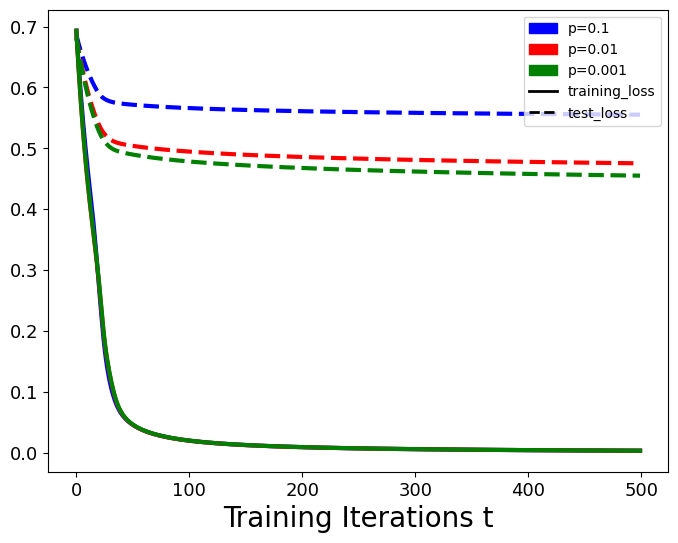

In [8]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
matplotlib.rcParams['text.usetex'] = False

training_loss_list1 = np.loadtxt('training_loss_list0.1.npy')
test_loss_list1 = np.loadtxt('test_loss_list0.1')

training_loss_list2 = np.loadtxt('training_loss_list0.01.npy')
test_loss_list2 = np.loadtxt('test_loss_list0.01')

training_loss_list3 = np.loadtxt('training_loss_list0.001.npy')
test_loss_list3 = np.loadtxt('test_loss_list0.001')


matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13
matplotlib.rcParams['figure.figsize'] = [8, 6]

plt.figure(0)


plt.plot(np.array(range(500)), np.mean(np.array(training_loss_list1), axis=0),
         label="V_signals", linewidth=3,color='blue')

# 绘制测试损失折线图
plt.plot(np.array(range(500)), np.mean(np.array(test_loss_list1), axis=0),
         label="V_noises", linewidth=3,linestyle='--',color='blue')


plt.plot(np.array(range(500)), np.mean(np.array(training_loss_list2), axis=0),
         label="V_signals", linewidth=3,color='red')

# 绘制测试损失折线图
plt.plot(np.array(range(500)), np.mean(np.array(test_loss_list2), axis=0),
         label="V_noises", linewidth=3,linestyle='--',color='red')


plt.plot(np.array(range(500)), np.mean(np.array(training_loss_list3), axis=0),
         label="V_signals", linewidth=3,color='green')

# 绘制测试损失折线图
plt.plot(np.array(range(500)), np.mean(np.array(test_loss_list3), axis=0),
         label="V_noises", linewidth=3,linestyle='--',color='green')


color_patches = [Patch(facecolor='blue', edgecolor='blue', label='p=0.1'),
                 Patch(facecolor='red', edgecolor='red', label='p=0.01'),
                 Patch(facecolor='green', edgecolor='green', label='p=0.001')]

line_patches = [Line2D([0], [0], color='black', lw=2, linestyle='-', label='training_loss'),
                Line2D([0], [0], color='black', lw=2, linestyle='--', label='test_loss')]

handles = color_patches + line_patches
plt.legend(handles=handles, loc='upper right')


plt.xlabel('Training Iterations t', size=20)
